In [ ]:
import math

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

# Attention is All You Need

На прошлых практических занятиях мы приобрели некоторый опыт работы с моделями Seq2Seq на основе RNN.

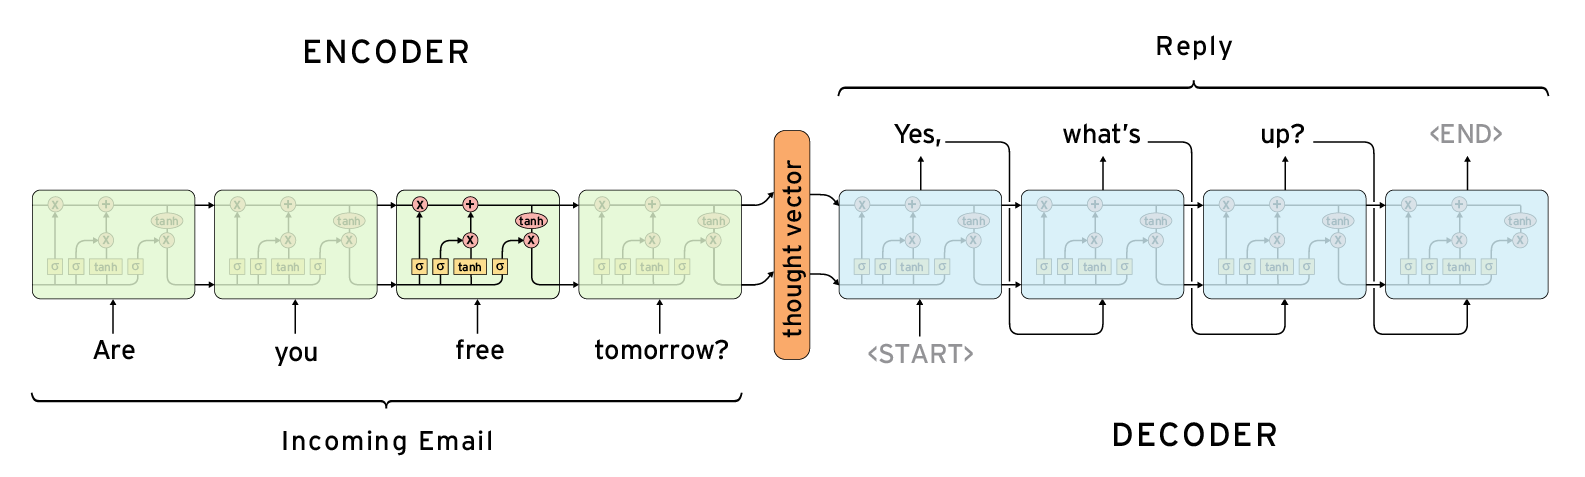

Основные выводы были следующими:
- Требуют много компьюта на forward и backward pass;
- Плохо параллелятся, плохо используют ресурсы GPU;
- Страдают от взрыва и затухания градиентов.
- В целом, довольно... запутаны
    
Даже применяя механизм Attention, нам не удалось за разумное время достичь сносных результатов в двух тренировочных задачах.

**Но зачем вообще нам RNN?**

- С помощью RNN мы последовательно считывали входные токены и последовательно генерировали выходные токены. RNN за счёт своих свойств "запомнинать" предыдущие состояния позволяла в итоге сформировать осмысленный вектор текста с учётом расположения токенов, на основе чего можно было делать предсказания. В декодере - аналогично.

Но обязательно ли считывать токены последовательно? 

Потребовалось 3 года (с момента изобретения механизма Attention) чтобы понять и показать, что нет.

В 2017 году инженерами Google была предложена следующая архитектура на основе механизма внимания, не использующая RNN - ***Transformer***:

![transformer architecrture graph](../images/2017_AttentionIsAllYouNeed_FIG1.png)

Эта архитектура произвела революцию как в задачах обработки языка, так и в других доменах ML и науки в целом. Например, в том же 2017 году нейросетевые модели впервые заменили модели статистического перевода в сервисе GoogleTranslate.

Это неудивительно: эта архитектура обучается в 10-100 раз эффективнее чем существовавшие на тот момент альтернативы:
![resource comprasion table](../images/2017_AttentionIsAllYouNeed_Tab2.png)

Оригинальная статья *Attention is All You Need* (https://arxiv.org/pdf/1706.03762) в журнале *Advances in neural information processing systems* к настоящему моменту собрала более 200 тысяч цитирований (т.е. примерно по 70 цитирований в день!).

![attention article citation plot](../images/AttentionIsAllYouNeed%20citation%20count.png)

# 1. Архитектура Transformer

![transformer blackbox](../images/IllTransformer_JAlammar_FIG1.png)

Если смотреть на Transformer как на черный ящик, он делает следующее:
1. Считывает (параллельно) входную последовательность токенов;
2. На основе считанной последовательности предсказывает другую последовательность токенов в авторегрессионном режиме;

Внутри Transformer, подобно Seq2Seq, состоит из энкодеров и декодеров:

![transformer structure](../images/IllTransformer_JAlammar_FIG3.png)

Отличительная особенность архитектуры, кроме параллельного чтения входных данных - равенство размерностей входа/выхода всех энкодеров и декодеров.

Это не вполне общее требование, однако оно:
- Удобно с точки зрения архитектуры, поскольку упрощает многие матричные операции и позволяет, например, выполнять skip connection между этими слоями без дополнительных преобразований; 
- Обеспечивает эффективное распространение градиентов вдоль всех слоёв;

Рассмотрим внимательнее устройство каждого блока трансформера, начнем с эмбеддингов.

## 1.1. Embedding layer


Эмбеддинги в случае трансформеров устроены также, как и раньше - это (возможно, обучаемая) матрица, которая сопоставляет каждому токену вектор по его id.

Однако на слой эмбеддингов обычно накладывают дополнительный функционал, позволяющий учитывать расположение токенов в последовательности - ***Positional Encodings***.

Наиболее распространённый вариант - фиксированные энкодинги вида:
$$
\text{PE}_{(\text{pos}, 2i)} = \sin{\left( \frac{\text{pos}}{{10000}^{{2i}/{d_{\text{emb}}}}}\right)} = \sin{\left( \text{pos} \cdot e^{- 4\ln{10} \frac{2i}{d_{\text{emb}}}}\right)} \\
\text{PE}_{(\text{pos}, 2i+1)} = \cos{\left( \frac{\text{pos}}{{10000}^{{2i}/{d_{\text{emb}}}}}\right)} = \cos{\left( \text{pos} \cdot e^{- 4\ln{10} \frac{2i}{d_{\text{emb}}}}\right)}
$$
Здесь $pos$ - индекс позиции токена в предложении, а $i$ пробегает по размерности вложения (т.е. перебирает все компоненты вектора вложения токена).

*Почему именно такой вид*: эти вектора по построению обладают одним полезным свойством:

Пусть $\bar{x}_k = \{ \text{PE}_{(k, i)} \} $ - позиционный вектор для токена на $k$-той позиции. Тогда для токенов на позициях $k$ и $m$:
$$
(\bar{x}_{k}, \bar{x}_{m}) \sim \frac{1}{| k - m |}
$$
Т.е. скалярное произведение таких векторов обратно пропорционально расстоянию между токенами в последовательности. Именно это свойство выбранных векторов позволит модели учитывать относительное расположение токенов.

*Замечания*: Именно их мы отрезали от слоя эмбеддингов MobileBert на прошлых занятиях (там были ещё задаче-специфичные эмбеддинги сегмента текста, которые позволяют, например, различать вопрос и ответ, принадлежность токенов отдельным предложениям и т.д.)


In [86]:
# Реализуем позиционное кодирование:

class SinEncoding(nn.Module):
    """
    Fixed sinusoidal positional encodigs
    """

    def __init__(self, emb_dim: int):
        """
        

        Args:
            - emb_dim: int
        """
        super().__init__()
        self.emb_dim = emb_dim   
        idxs = torch.arange(emb_dim // 2)
        self.weight = torch.exp(- 4 * torch.log(torch.Tensor([10.0])) / emb_dim * idxs)
        self.weight.requires_grad = False
        
    def __call__(self, pos: torch.Tensor):
        '''
        Get batched positional encodings

        Args:
            - pos: torch.Tensor [B]- positions
        '''
        angles = torch.outer(pos, self.weight)
    
        pe = torch.zeros(*pos.shape, self.emb_dim)
        pe[..., 0::2] = torch.sin(angles)
        pe[..., 1::2] = torch.cos(angles)
        
        return pe

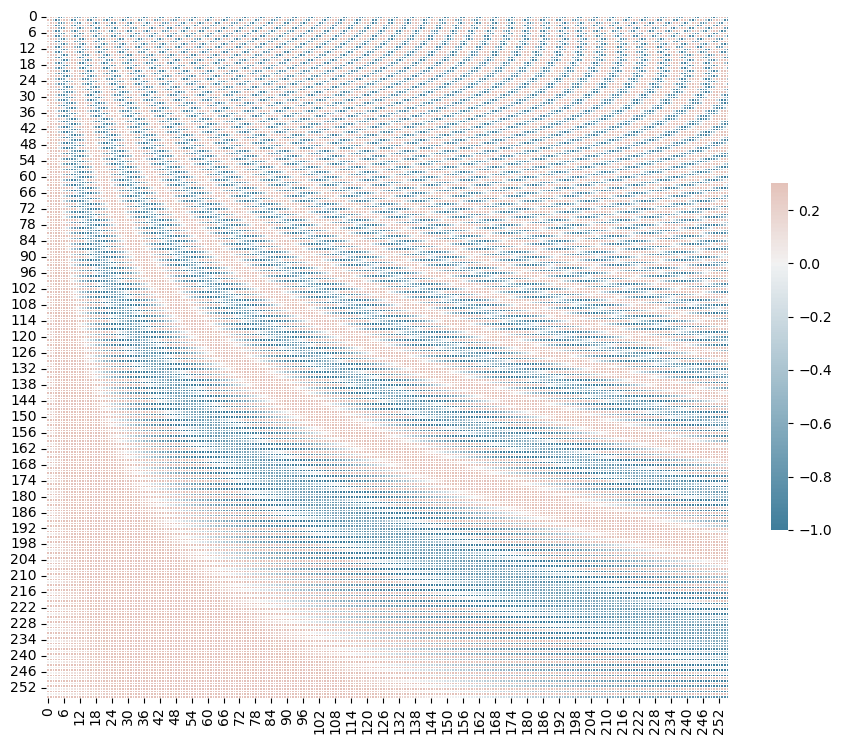

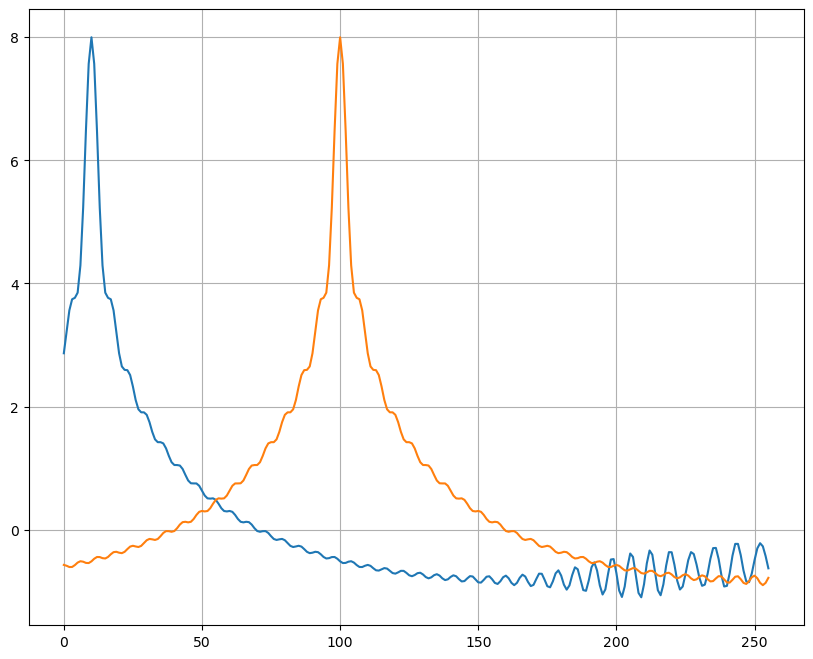

In [ ]:
input_shape = {'seq_len': 256, 'emb_dim': 32}

pos_encodings = SinEncoding(input_shape['emb_dim'])
pos = torch.IntTensor([*range(input_shape['seq_len'])])

X = pos_encodings(pos)

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(X.T, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

k1, k2 = 10, 100

y1 = X @ X[k1] / math.sqrt(input_shape['seq_len'])
y2 = X @ X[k2] / math.sqrt(input_shape['seq_len'])

fig, ax = plt.subplots(1,1, figsize=(10, 8))

ax.plot(pos, y1)
ax.plot(pos, y2)
ax.grid('on')

plt.show()

In [ ]:
class Embedding(nn.Embedding):

    def __init__(self,
            embedding: nn.Embedding,
            dropout: float = 0.1,
            ):        
        super().__init__()
        
        self.token_embedding = embedding
        self.embedding_dim = embedding.embedding_dim
        self.pos_encoding = SinEncoding(self.embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, X):
        """
        
        Args:
            - X: torch.IntTensor [B, L]
        Returns:
            - X: torch.Tensor [B, L, D]
        """
        pos = torch.arange(X.shape[-1])
        X = self.token_embedding(X) #* math.sqrt(self.d_emb)
        X += self.pos_encoding(pos)
        return self.dropout(X)
    

## 1.2 Encoder layer

![Encoder internal structure](../images/Encoder_Block.png)

### 1.2.1. Self-Attention

Механизм внимания в Seq2Seq на основе RNN работал со скрытыми состояниями энкодера и декодера. 

Здесь у нас такого варианта нет - декодер не имеет каких-либо внутренних состояний. Реализовать внимание на входах и выходах слоя внимания тоже нельзя - это снова будет RNN, чего мы не хотим.

Единственный вариант - сравнивать входящую последовательность саму с собой, т.е. самовнимание.

Такой механизм выделяет наиболее важные токены внутри последовательности на основе содержания самой этой последовательности.

### 1.2.3. QKV Attention

![QKV attention](../images/QKV_Attention.png)

$$ \text{Attention}(Q, K, V) = \text{Softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right)V $$

![](../images/IllTransformer_JAlammar_FIG8.png)

In [ ]:
class QKVAttention(nn.Module):
    
    def __init__(self, emb_dim, key_dim, dropout=0.1):
        super().__init__()
        self.emb_dim = emb_dim
        self.key_dim = key_dim

        self.WQ = nn.Linear(emb_dim, key_dim)
        self.WK = nn.Linear(emb_dim, key_dim)
        self.WV = nn.Linear(emb_dim, key_dim)
        self.norm_mul = 1/math.sqrt(key_dim)
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None
        
    def forward(self, X):
        """
        Args:
            - X: torch.Tensor [..., L, D]
        Returns:
            - X: torch.Tensor [..., L, K]
        """
        query = self.WQ(X) # [.., L, K]
        key = self.WK(X) # [..., L, K]
        value = self.WV(X) #[..., L, K]
        
        energy = self.norm_mul * torch.einsum('...LK, ...LK -> ...L', query, key)

        self.attn_weights = F.softmax(energy, dim=-1)
        
        attn_outputs = value*self.attn_weights.unsqueeze(-1)
        
        return self.dropout(attn_outputs)

In [77]:
input_shape = {'batch': 2, 'seq_len': 11, 'emb_dim': 32}
X = torch.randn(*input_shape.values())

TestAttn = QKVAttention(input_shape['emb_dim'], 32, dropout=0.1)
TestAttn(X)

tensor([[[ 4.1913e-02, -8.6328e-02,  2.5441e-02, -1.8281e-02,  0.0000e+00,
           6.8580e-02,  4.7202e-02,  1.0241e-01,  5.0595e-02, -4.2117e-02,
          -5.7458e-02, -4.8277e-02, -7.0056e-02, -1.4211e-02, -5.3046e-03,
          -6.4152e-03,  4.2258e-02,  1.4243e-02, -5.0434e-02,  4.3451e-02,
           8.9616e-03, -1.3626e-02, -8.8470e-02,  1.4298e-03,  5.2981e-02,
          -1.1546e-02,  5.1145e-03, -9.4725e-02, -1.2899e-02, -3.5745e-02,
          -5.3040e-03,  8.5865e-02],
         [-3.9899e-02, -3.7408e-03,  2.8433e-02, -7.8672e-02,  4.4673e-02,
           5.3418e-02,  4.2603e-02, -1.2280e-02,  8.2662e-02, -1.1958e-02,
           7.3059e-03,  8.9596e-02,  0.0000e+00,  8.8361e-02, -1.3626e-02,
           0.0000e+00,  4.2369e-05, -9.3329e-02,  2.9014e-02, -1.9372e-02,
           4.6605e-02,  4.4666e-02, -3.7846e-02,  1.5156e-02,  2.1031e-02,
          -2.0423e-02,  3.1221e-03,  5.2750e-02, -3.0809e-02,  6.1519e-02,
           6.0676e-02,  8.7237e-03],
         [ 4.6178e-02, -1.



### 1.2.3. Multi-Head Attention

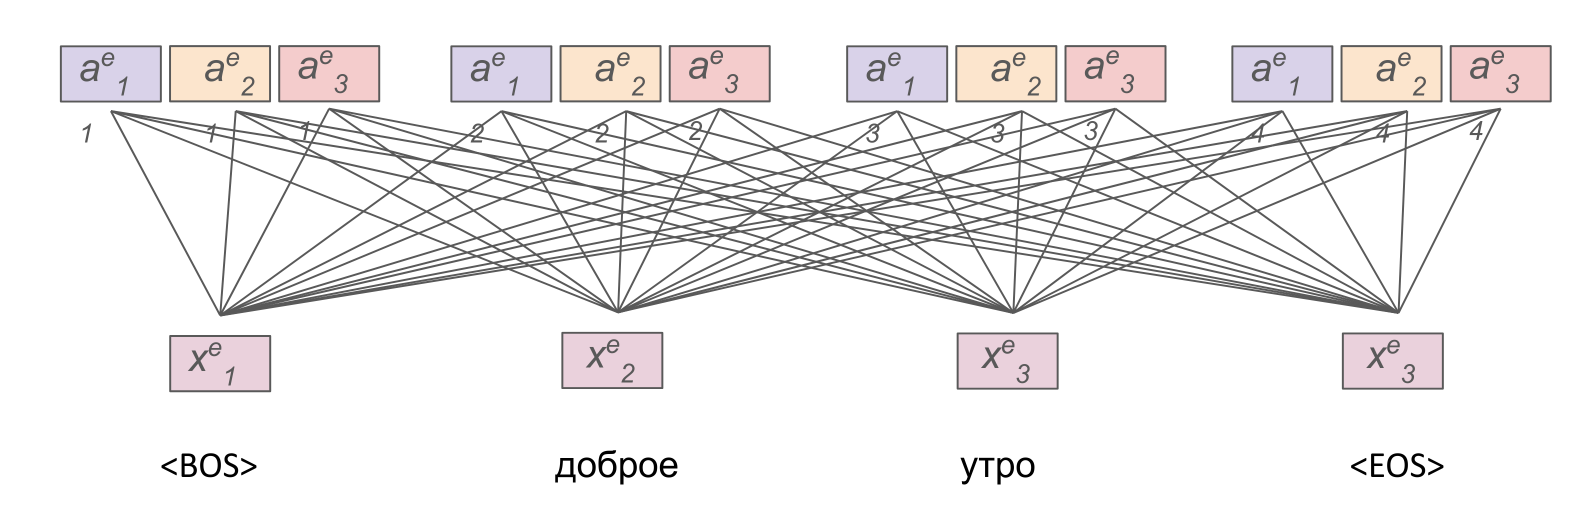







In [78]:
class MultiheadAttention(nn.Module):

    def __init__(self, emb_dim: int, n_heads: int, key_dim: int = None, AttentionImpl = QKVAttention, **kwargs):
        super().__init__()
        self.n_heads = n_heads
        if key_dim:
            self.key_dim = key_dim
        else:
            self.key_dim = emb_dim // n_heads

        self.heads = nn.ModuleList(
            [AttentionImpl(emb_dim, self.key_dim, **kwargs) for i in range(n_heads)]
            )
        self.WO = nn.Linear(self.key_dim*n_heads, emb_dim)

    def forward(self, X: torch.Tensor):

        outp = []
        
        for head in self.heads:
            outp.append(head(X))

        outp = self.WO(torch.cat(outp, dim=-1))

        return outp

In [79]:
MHA = MultiheadAttention(64, 8, 3, dropout=0.1)

input_shape = {'batch': 2, 'seq_len': 11, 'emb_dim': 64}
X = torch.zeros(*input_shape.values())

MHA.forward(X).shape

torch.Size([2, 11, 64])

### 1.2.4. Add&Norm

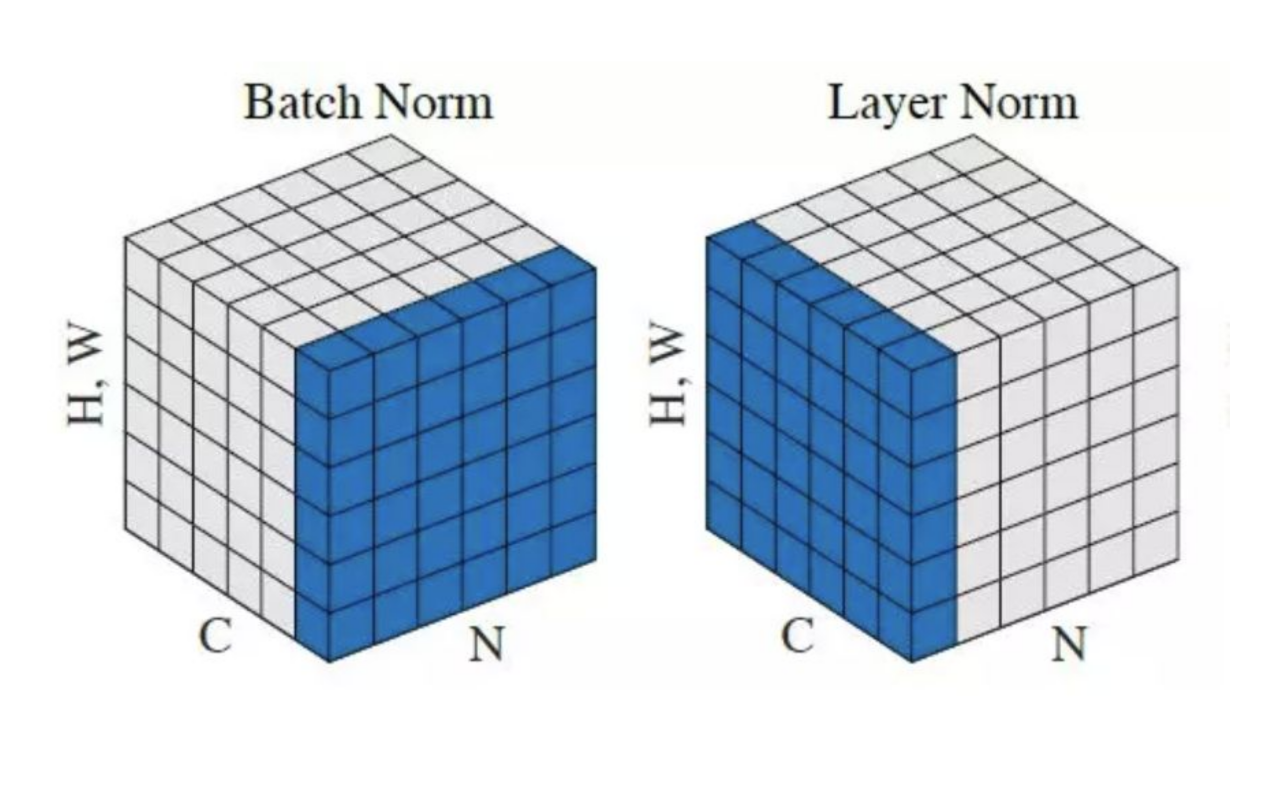

In [80]:
class LayerNorm(nn.Module):

    def __init__(self, bias=True, eps=1e-8):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1))
        self.beta = nn.Parameter(torch.zeros(1), requires_grad=bias)
        self.eps = eps
    
    def forward(self, X: torch.Tensor):
        
        mean = X.mean(dim=-1).unsqueeze(-1)
        std = X.std(dim=-1).unsqueeze(-1)

        X = (X - mean)/(std + self.eps)

        return X*self.gamma + self.beta

In [81]:
LN = LayerNorm()

input_shape = {'batch': 2, 'seq_len': 3, 'emb_dim': 64}
X = torch.randn(*input_shape.values())*5.0 - 2.0

print(f'X input statistics:')
print(f'X mean: {X.mean(dim=-1)}')
print(f'X std: {X.std(dim=-1)}')

X = LN(X)

print(f'X output statistics:')
print(f'X mean: {X.mean(dim=-1)}')
print(f'X std: {X.std(dim=-1)}')


X input statistics:
X mean: tensor([[-1.7712, -1.4624, -1.0805],
        [-2.2238, -3.1056, -3.2898]])
X std: tensor([[4.4776, 5.0163, 4.4179],
        [4.7342, 4.8452, 4.8117]])
X output statistics:
X mean: tensor([[ 7.4506e-09, -5.5879e-09, -1.1176e-08],
        [-1.4901e-08,  7.4506e-09, -7.4506e-09]], grad_fn=<MeanBackward1>)
X std: tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]], grad_fn=<StdBackward0>)


### 1.2.5 Encoder implementation

![transformer encoder stack](../images/Encoder_Block.png)

In [84]:
# Реализуем энкодер с MHA QKV attention

class TransformerEncoder(nn.Module):

    def __init__(self, emb_dim: int, n_heads: int, key_dim: int=None, dropout=0.1, ln_bias: bool=True, eps: float=1e-8):
        """
        Args:
            - emb_dim - embedding dimension
            - n_heads - number of attention heads
            - key_dim
        """
        super().__init__()
        self.Attention = MultiheadAttention(emb_dim=emb_dim, n_heads=n_heads, key_dim=key_dim, dropout=dropout)
        self.LayerNorm1 = LayerNorm(bias=ln_bias, eps=eps)
        self.FFN = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Dropout(dropout)
            )
        self.LayerNorm2 = LayerNorm(bias=ln_bias, eps=eps)

    def forward(self, X: torch.Tensor):

        X_a = self.Attention(X)
        X = self.LayerNorm1(X + X_a)
        X_ffn = self.FFN(X)
        X = self.LayerNorm2(X + X_ffn)

        return X


In [85]:
# Проверяем:
input_shape = {'batch': 2, 'seq_len': 3, 'emb_dim': 32}
X = torch.randn(*input_shape.values())*5.0 - 2.0

ENC = TransformerEncoder(input_shape['emb_dim'], 8)

print(f'X input statistics:')
print(f'X mean: {X.mean(dim=-1)}')
print(f'X std: {X.std(dim=-1)}')

X = ENC(X)

print(f'X output statistics:')
print(f'X shape: {X.shape}')
print(f'X mean: {X.mean(dim=-1)}')
print(f'X std: {X.std(dim=-1)}')


X input statistics:
X mean: tensor([[-0.8173, -1.4688, -1.2719],
        [-2.7954, -2.3200, -2.4095]])
X std: tensor([[4.9523, 3.8755, 4.7556],
        [5.0319, 5.2087, 5.7270]])
X output statistics:
X shape: torch.Size([2, 3, 32])
X mean: tensor([[-1.3970e-08, -1.4901e-08,  1.4901e-08],
        [-9.3132e-09, -2.9802e-08, -2.7940e-08]], grad_fn=<MeanBackward1>)
X std: tensor([[1., 1., 1.],
        [1., 1., 1.]], grad_fn=<StdBackward0>)


Показано, что PreLN более стабильно для моделей с большим числом слоев, чем PostLN

![](../images/PreLN_and_PostLN.svg)
https://aclanthology.org/2020.emnlp-main.463/



## 1.3 Decoder

![](../images/Decoder_Block.png)

### 1.3.1. Masked attention

![](../images/MaskedAttention.png)

Реализовать причинную маску можно различными способами - как отдельный класс `MaskedAttention` либо внутри самого трансформера. Мы выберем второй вариант, т.к. в таком случае оверхэд меньше (но он в любом случае незначителен), да и класс трансформера мы ещё не реализовали.

### 1.3.2. Cross attention

![](../images/cross_attention.webp)


In [ ]:
#
class CrossAttention(QKVAttention):

    def __init__(self, emb_dim: int, key_dim: int):
        super().__init__(emb_dim=emb_dim, key_dim=key_dim)

    def forward(self, X_enc: torch.Tensor, X_dec: torch.Tensor):
        
        query = self.WQ(X_dec) # [.., L, K]
        key = self.WK(X_enc) # [..., L, K]
        value = self.WV(X_enc) #[..., L, K]
        
        energy = self.norm_mul * torch.einsum('...LK, ...LK -> ...L', query, key)

        self.attn_weights = F.softmax(energy, dim=-1)
        
        attn_outputs = value*self.attn_weights.unsqueeze(-1)
        
        return attn_outputs

In [ ]:
TestAttn = CrossAttention(32, 8)

input_shape = {'batch': 2, 'seq_len': 3, 'emb_dim': 32}
X_enc = torch.ones(*input_shape.values())
X_dec = torch.randn(*input_shape.values())

TestAttn(X_enc, X_dec)

tensor([[[-0.2417, -0.0932,  0.4074, -0.2124,  0.7670,  0.3691, -0.1875,
           0.4990],
         [-0.1161, -0.0448,  0.1957, -0.1020,  0.3684,  0.1773, -0.0901,
           0.2397],
         [-0.1171, -0.0452,  0.1973, -0.1029,  0.3715,  0.1788, -0.0908,
           0.2417]],

        [[-0.1329, -0.0512,  0.2240, -0.1168,  0.4216,  0.2029, -0.1031,
           0.2743],
         [-0.1495, -0.0577,  0.2520, -0.1314,  0.4745,  0.2283, -0.1160,
           0.3087],
         [-0.1925, -0.0742,  0.3245, -0.1692,  0.6108,  0.2940, -0.1493,
           0.3974]]], grad_fn=<MulBackward0>)

In [35]:
class CrossMultiheadAttention(nn.Module):

    def __init__(self, emb_dim: int, n_heads: int, key_dim: int = None, AttentionImpl = CrossAttention, **kwargs):
        super().__init__()
        self.n_heads = n_heads
        if key_dim:
            self.key_dim = key_dim
        else:
            self.key_dim = emb_dim // n_heads

        self.heads = nn.ModuleList(
            [AttentionImpl(emb_dim, self.key_dim, **kwargs) for i in range(n_heads)]
            )
        self.WO = nn.Linear(self.key_dim*n_heads, emb_dim)

    def forward(self, X: torch.Tensor, X_enc: torch.Tensor):

        outp = []
        
        for head in self.heads:
            outp.append(head(X, X_enc))

        outp = self.WO(torch.cat(outp, dim=-1))

        return outp

In [ ]:
TestAttn = CrossMultiheadAttention(32, 8)

input_shape = {'batch': 2, 'seq_len': 3, 'emb_dim': 32}
X_enc = torch.ones(*input_shape.values())
X_dec = torch.randn(*input_shape.values())

TestAttn(X_enc, X_dec)

tensor([[[ 0.0304,  0.1593,  0.0092, -0.0834, -0.0461, -0.1331, -0.0895,
           0.0064, -0.2255, -0.1002,  0.3017,  0.1185, -0.1068,  0.1367,
           0.1985,  0.2262, -0.2029, -0.0996, -0.0903,  0.0415, -0.0594,
           0.2686,  0.0320,  0.1516, -0.2491, -0.0699,  0.3315, -0.1253,
           0.1384, -0.1172, -0.0604,  0.2972],
         [ 0.0233,  0.1663,  0.0230, -0.0645, -0.0366, -0.0952, -0.0600,
           0.0045, -0.2126, -0.1243,  0.2451,  0.1461, -0.1451,  0.0939,
           0.1862,  0.2381, -0.1975, -0.1008, -0.0781,  0.0996, -0.0593,
           0.2777,  0.0280,  0.1613, -0.2257, -0.0112,  0.3046, -0.0819,
           0.1451, -0.0462, -0.0640,  0.2770],
         [ 0.0138,  0.1089,  0.0335, -0.0730, -0.0037, -0.1246, -0.1302,
           0.0030, -0.2096, -0.0999,  0.2976,  0.1029, -0.0804,  0.1474,
           0.1812,  0.2027, -0.1751, -0.0984, -0.0718,  0.0313, -0.0438,
           0.2189,  0.0226,  0.1390, -0.2502, -0.0635,  0.2862, -0.0974,
           0.1312, -0.1236, -0

### 1.3.3. Decoder implementation

In [55]:
class TransformerDecoder(nn.Module):

    def __init__(self, emb_dim: int, n_heads: int, key_dim:int=None, ln_bias: bool = True, eps: float = 1e-8):
        super().__init__()
        self.Attention = MultiheadAttention(emb_dim=emb_dim, n_heads=n_heads, key_dim=key_dim)
        self.LayerNorm1 = LayerNorm(bias=ln_bias, eps=eps)
        self.CrossAttention = CrossMultiheadAttention(emb_dim=emb_dim, n_heads=n_heads, key_dim=key_dim)
        self.LayerNorm2 = LayerNorm(bias=ln_bias, eps=eps)
        self.FFN = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            )
        self.LayerNorm3 = LayerNorm(bias=ln_bias, eps=eps)
    
    def forward(self, X: torch.Tensor, X_enc: torch.Tensor):
        
        X_a = self.Attention(X)
        X = self.LayerNorm1(X + X_a)
        X_ca = self.CrossAttention(X, X_enc)
        X = self.LayerNorm2(X + X_ca)
        X_ffn = self.FFN(X)
        X = self.LayerNorm3(X + X_ffn)

        return X

In [58]:
# Decoder test

input_shape = {'batch': 2, 'seq_len': 3, 'emb_dim': 32}
x = torch.randn(*input_shape.values())*5.0 - 2.0
x_enc = torch.randn(*input_shape.values())*5.0 - 2.0

DEC = TransformerDecoder(input_shape['emb_dim'], 4)

print(f'X input statistics:')
print(f'X mean: {X.mean(dim=-1)}')
print(f'X std: {X.std(dim=-1)}')

x = DEC(x, X_enc)

print(f'X output statistics:')
print(f'X shape: {X.shape}')
print(f'X mean: {X.mean(dim=-1)}')
print(f'X std: {X.std(dim=-1)}')

print(x)

X input statistics:
X mean: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
X std: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
X output statistics:
X shape: torch.Size([2, 11, 64])
X mean: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
X std: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[[ 1.1330,  0.0210, -0.0204,  0.4875, -0.9164,  0.0050, -1.0600,
          -2.1140,  0.4689,  0.4200,  0.6509,  0.9835, -0.7143, -0.4737,
          -1.1516, -0.4125,  0.0994,  1.3323, -0.8368,  1.3922, -1.2368,
           1.8192, -1.2788, -1.0848,  1.0824, -0.0166,  0.2227,  1.2415,
           0.6448, -1.4202,  1.2293, -0.4967],
         [-0.1001,  0.6942, -1.6290,  0.6780,  1.1594, -0.3986,  1.5240,
           0.8816,  2.0879, -0.8110, -0.1197,  0

# 2. Transformer implementation


In [ ]:
from typing import List

class Transformer(nn.Module):

    def __init__(self,
                 embedding: nn.Embedding,
                 encoder_heads: int | List[int],
                 decoder_heads: int | List[int] = None,
                 encoder_key_dim: int | List[int] = None,
                 decoder_key_dim: int | List[int] = None,
                 dropout: float = 0.1,
                 ln_bias: bool = True,
                 eps: float = 1e-8,
                 ):
        
        self.emb_dim = embedding.embedding_dim
        self.vocab_size = embedding.vocab_size
        self.embedding = Embedding(embedding, dropout)
        self.PAD_id = 0

        self.encoder_heads = encoder_heads
        self.n_encoders = len(encoder_heads)

        if decoder_heads is None:
            decoder_heads = encoder_heads
        self.decoder_heads = decoder_heads
        self.n_decoders = len(decoder_heads)
        
        if isinstance(encoder_key_dim, (int, type(None))):
            encoder_key_dim = [encoder_key_dim] * len(self.n_encoders)
        elif isinstance(encoder_key_dim, List):
            assert len(encoder_key_dim) == self.n_encoders,\
                f"Encoders key dimensions are specified as list, but it's len does not match n_encoders:\
                  got {len(encoder_key_dim)}, expected {self.n_encoders}"
        
        if isinstance(decoder_key_dim, (int, type(None))):
            decoder_key_dim = [decoder_key_dim] * len(self.n_decoders)
        elif isinstance(decoder_key_dim, List):
            assert len(decoder_key_dim) == self.n_decoders,\
                f"Decoders key dimensions are specified as list, but it's len does not match n_decoders:\
                  got {len(decoder_key_dim)}, expected {self.n_decoders}"
            
        self.encoder_key_dim = encoder_key_dim
        self.decoder_key_dim = decoder_key_dim

        self.encoders = nn.ModuleDict(**{f'Enc{i}': TransformerEncoder(
            emb_dim=self.emb_dim, n_heads=encoder_heads[i], 
            key_dim=encoder_key_dim[i], dropout=dropout) for i in range(self.n_encoders)
            })
        
        self.decoders = nn.ModuleDict(**{f'Dec{i}': TransformerDecoder(
            emb_dim=self.emb_dim, n_heads=decoder_heads[i], 
            key_dim=decoder_key_dim[i], dropout=dropout) for i in range(self.n_decoders)
            })

        self.projection = nn.Linear(self.emb_dim, self.vocab_size, bias=False)

    def forward(self, X):

        for key, encoder in self.encoders:
            # YOUR CODE
            pass

        for key, decoder in self.decoders:
            # YOUR CODE
            pass

        logits = None # YOUR CODE

        return logits

    def casual_mask(self, seq_len):
        """
        Create a causal mask for autoregressive attention.
        
        Args:
            seq_len: Length of the sequence
        
        Returns:
            Causal mask of shape (seq_len, seq_len)
        """
        mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
        return mask

    def padding_mask(self, X_batch):
        """
        Create a padding mask for a batch of sequences.
        
        Args:
            X_batch: Batch of sequences, shape (batch_size, seq_len)
            padding_token_id: ID of the padding token
        
        Returns:
            Padding mask of shape (batch_size, seq_len, seq_len)
        """
        batch_size, seq_len = X_batch.shape
        padded = torch.zeros_like(X_batch).float().masked_fill(X_batch == self.PAD_id, float('-inf'))
        mask = torch.zeros(batch_size, seq_len, seq_len) + padded[:,:,None] + padded[:,None,:]
        return mask[:, None, :, :]


In [ ]:
# Transformer test
emb_dim = 64
embedding = nn.Embedding(30244, 64)
input_shape = {'batch': 2, 'seq_len': 3}



# 3. Заключение. BERT и GPT

![bert vs gpt](../images/bert_vs_gpt_1d8df8bea4_9539ededda.webp)